# WikiPathways vs BEL gene sets comparison

This notebook calculates the Jaccard index for gene sets in the WikiPathways database and gene sets in BEL graphs for each pathway in the database

In [1]:
import os
import itertools as itt
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

from pybel import BELGraph, from_pickle

from pathme.constants import WIKIPATHWAYS_BEL
from pathme.utils import get_files_in_folder

from bio2bel_wikipathways.manager import Manager

In [2]:
# Initiate WikiPathways Manager
wikipathways_manager = Manager()

### Get gene sets for each WikiPathways pathway in the WikiPathways database.

In [3]:
wikipathways_genes_set = wikipathways_manager.export_gene_sets()

### Get gene sets for each WikiPathways pathway BEL graph

In [4]:
# Get list of BEL graph pickles
pickles = get_files_in_folder(WIKIPATHWAYS_BEL)

In [5]:
def get_genes_from_pickles(resource_folder, pickles):
    """Get BEL graph gene set for all pathways in resource.

    :param list pickles: list of BEL graph pickles
    :return: BEL graph gene sets for each pathway in resrouce
    :rtype: dict[str,set]
    """
    pathway_genes_dict = {}
    
    for file in pickles:

        graph = from_pickle(os.path.join(resource_folder,file))

        # Get gene set for pathway 
        gene_set = get_genes_in_graph(graph)
        file = file.strip('.pickle')
        file = wikipathways_manager.get_pathway_by_id(file)
        pathway_genes_dict[str(file)] = gene_set

        
    return pathway_genes_dict


In [6]:
def get_genes_in_graph(graph):
    """Get BEL graph gene set for a pathway.

    :param pybel.BELGraph graph: BEL Graph
    :return: BEL graph gene set  
    :rtype: set
    """
    gene_set = set()
    
    for node, data in graph.nodes(data=True):
        if node.function in {'Protein', 'RNA','Gene'} and node.namespace == 'HGNC':
            gene_set.add(node.name)
            
    return gene_set

### For each pathway in the WikiPathways PATHWAY database, calculate the Jaccard index for gene sets from the database and from BEL graphs 

In [7]:
def jaccard_similarity(database_gene_set, bel_genes_set):
    """Get Jaccard similarity for gene sets in database and BEL graphs.

    :param dict database_gene_set: gene sets for each pathway in database
    :param dict bel_genes_set: gene sets for each BEL graph
    :return: similarity index 
    :rtype: int
    """    
    jaccard_similarities = []
    count = 0
    count_no_similarity = 0 
    
    for (database_key, database_value), (bel_key, bel_value) in itt.product(database_gene_set.items(),bel_genes_set.items()):
        
        if database_key != bel_key:
            continue

        intersection = len(set.intersection(database_value, bel_value))
        union = len(database_value.union(bel_value))
        jaccard_index = intersection/union
        jaccard_similarities.append(jaccard_index)
        
        if jaccard_index == 1.0:
            count += 1
            
        elif jaccard_index == 0.0:
            count_no_similarity += 1
            
    print('{} gene sets in the database and BEL graphs have a similarity of 100%.'.format(count))
    print('{} gene sets in the database and BEL graphs have a similarity of 0%.'.format(count_no_similarity))
    
    return jaccard_similarities

In [8]:
bel_genes_set = get_genes_from_pickles(WIKIPATHWAYS_BEL,pickles)

In [9]:
jaccard_similarities = jaccard_similarity(wikipathways_genes_set, bel_genes_set)

26 gene sets in the database and BEL graphs have a similarity of 100%.
35 gene sets in the database and BEL graphs have a similarity of 0%.


#### Visualize Jaccard index distribution

/home/sarah/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


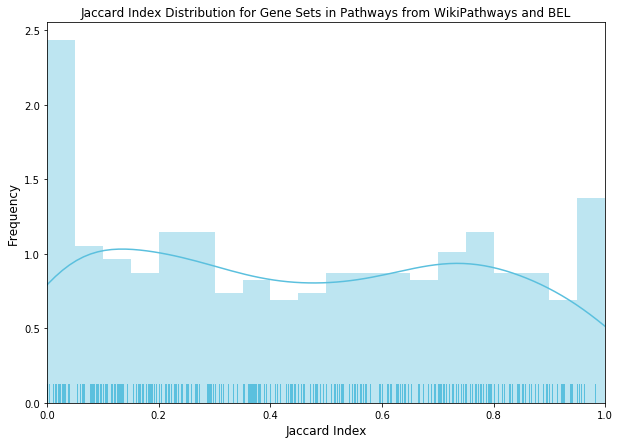

In [19]:
plt.figure(figsize=(10,7))
plt.title('Jaccard Index Distribution for Gene Sets in Pathways from WikiPathways and BEL', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Jaccard Index', fontsize=12)
plt.xlim(0,1)
sns.distplot(jaccard_similarities, rug=True,  bins=20, color='#5bc0de')